# SMC samplers

This tutorial gives a basic introduction to SMC samplers, and explains how to run the SMC samplers already implemented in particles. For a more advanced tutorial on how to design new SMC samplers, see the next tutorial. For more background on SMC samplers, check Chapter 17 of the book.

## SMC samplers: what for? 

A SMC sampler is a SMC algorithm that samples from some sequence of probability distributions $\pi_t$ (and compute their normalising constants). Examples of such sequences are: 

1. $\pi_t(\theta) = p(\theta|y_{0:t})$, the Bayesian posterior distribution of parameter $\theta$ given data $y_{0:t}$, for a certain model. 

2. A tempering sequence, $\pi_t(\theta) \propto \nu(\theta) L(\theta)^{\gamma_t}$ ,and the $\gamma_t$'s form an increasing sequence of exponents: $0=\gamma_0 < \ldots < \gamma_T=1$. You can think of $\nu$ being the prior, $L$ the likelihood function, and $\pi_T$ the posterior. However, more generally, tempering is a way to interpolate between any two distributions, $\nu$ and $\pi$, with $\pi(\theta) \propto \nu(\theta) L(\theta)$. 

We discuss first how to specify a sequence of the first type.

## Defining a Bayesian model

To define a particular Bayesian model, you must subclass `StaticModel`, and define method `logpyt`, which evaluates the log-likelihood of datapoint $Y_t$ given parameter $\theta$ and past datapoints $Y_{0:t-1}$). Here is a simple example: 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats

import particles
from particles import smc_samplers as ssp
from particles import distributions as dists

class ToyModel(ssp.StaticModel):
    def logpyt(self, theta, t):  # density of Y_t given theta and Y_{0:t-1}
        return stats.norm.logpdf(self.data[t], loc=theta['mu'],
                                 scale = theta['sigma'])

In words, we are considering a model where the observations are $Y_t\sim N(\mu, \sigma^2)$. The parameter is $\theta=(\mu, \sigma)$. Note the fields notation; more about this later. 

Class `ToyModel` implicitely defines the  likelihood of the considered model for any sample size (since the likelihood at time $t$ is  $p^\theta(y_{0:t})=\prod_{s=0}^t p^\theta(y_s|y_{0:s-1})$, and method `logpyt` defines each factor in this product). We now define the data and the prior: 

In [2]:
T = 1000
my_data = stats.norm.rvs(loc=3.14, size=T)  # simulated data
my_prior = dists.StructDist({'mu': dists.Normal(scale=10.),
                             'sigma': dists.Gamma()})

For more details about to define prior distributions, see the documentation of module `distributions`, or the previous [tutorial on Bayesian estimation of state-space models](Bayes_estimation_ssm.ipynb). Now that we have everything, let's specify our static model: 

In [3]:
my_static_model = ToyModel(data=my_data, prior=my_prior)

This time, object `my_static_model` entirely defines the posterior. 

In [4]:
thetas = my_prior.rvs(size=5) 
my_static_model.logpost(thetas, t=2)  # if t is omitted, gives the full posterior

array([-4154.38136426,   -42.27502399, -3496.17221975, -1896.54646176,
        -805.74556772])

The input of `logpost` and output of `myprior.rvs()` are [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html), that is, arrays with fields:

In [21]:
thetas['mu'][0]

-8.44275913062715

Typically, you won't need to call `logpost` yourself, this will be done by the SMC sampler for you. 

## IBIS

IBIS (iterated batch importance sampling) is the standard name for a SMC samplers that tracks a sequence of partial posterior distributions; i.e. $\pi_t$ is $p(\theta|y_{0:t})$, for $t=0,1,\ldots$. 

Module `smc_samplers` defines `IBIS` as a subclass of `FeynmanKac`. 

In [23]:
my_ibis = ssp.IBIS(my_static_model, len_chain=50)
my_alg = particles.SMC(fk=my_ibis, N=20, store_history=True)
my_alg.run()

Since we set `store_history` to `True`, the particles and their weights have been saved at every time (in attribute `hist`, see previous tutorials on smoothing). Let's plot the posterior distributions of $\mu$ and $\sigma$ at various times.

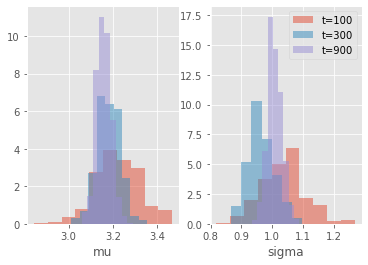

In [24]:
plt.style.use('ggplot')
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    for t in [100, 300, 900]:
        plt.hist(my_alg.hist.X[t].theta[p], weights=my_alg.hist.wgts[t].W, label="t=%i" % t, 
                 alpha=0.5, density=True)
    plt.xlabel(p)
plt.legend();

As expected, the posterior distribution concentrates progressively around the true values. 

As before, once the algorithm is run, `my_smc.X` contains the final particles. However, object `my_smc.X` is no longer a simple numpy array. It is a `ThetaParticles` object, with attributes:

* `theta`: a structured array: as mentioned above, this is an array with fields; i.e. `my_smc.X.theta['mu']` is a (N,) array that contains the the $\mu-$component of the $N$ particles; 
* `lpost`: a 1D numpy array that contains the target (posterior) log-density of each of the particles;
* `shared`: a dictionary that contains "meta-data" on the particles; for instance `shared['acc_rates']` is a list of the acceptance rates of the successive Metropolis steps. 

['nan%', 'nan%', 'nan%', 'nan%', 'nan%', '39.24%', '30.92%', '33.31%', '33.49%', '36.74%', '37.66%', '33.99%', '36.55%']


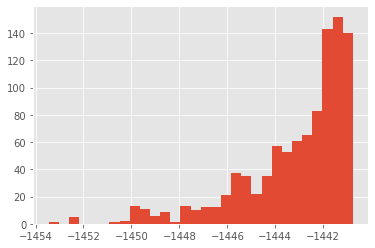

In [25]:
print(["%2.2f%%" % (100 * np.mean(r)) for r in my_alg.X.shared['acc_rates']])
plt.hist(my_alg.X.lpost, 30);

You do not need to know much more about class `ThetaParticles` for most practical purposes (see however the documention of module `smc_samplers` if you do want to know more, e.g. in order to implement other classes of SMC samplers).

## Waste-free versus standard SMC samplers

The library now implements by default waste-free SMC (Dau & Chopin, 2020), a variant of SMC samplers that keeps all the intermediate Markov steps (rather than "wasting" them). In practice, this means that, in the piece of code above:
* at each time $t$, $N=20$ are resampled, and used as a starting points of the MCMC chains; 
* the MCMC chains are run for 49 iterations, hence the chain length is 50 (parameter ``len_chain=50``)
* and since we keep all the intermediate steps, we get 50*20 = 1000 particles at each iteration. In particular, we do O(1000) operations at each step. (At time 0, we also generate 1000 particles.) 

Thus, the number of particles is actually `N * len_chain`; given this number of particles, the performance typically does not depend too much on `N` and `len_chain`, provided the latter is "big enough" (relative to the mixing of the MCMC kernels, see below).  

See Dau & Chopin (2020) for more details on waste-free SMC. If you wish to run a standard SMC sampler instead, you may set `wastefree=True`. For instance, this code above tracks 100 particles, and, each time the particles are resampled, then are moved through 10 MCMC steps. 

In [ ]:
my_ibis = ssp.IBIS(my_static_model, wastefree=False, len_chain=11)
my_alg = particles.SMC(fk=my_ibis, N=100, store_history=True)
my_alg.run()

## Regarding the Metropolis steps

As the text output of `my_alg.run()` suggests, the algorithm "resample-moves" whenever the ESS is below a certain threshold ($N/2$ by default). When this occurs, particles are resampled, and then moved through a certain number of Metropolis-Hastings steps. By default, the proposal is a Gaussian random walk, and both the number of steps and the covariance matrix of the random walk are chosen automatically as follows:
 
* the covariance matrix of the random walk is set to `scale` times   the empirical (weighted) covariance matrix of the particles. The default value for `scale` is $2.38 / \sqrt{d}$, where $d$ is the dimension of $\theta$. 
* the algorithm performs Metropolis steps until the relative increase of the  average distance between the starting point and the end point is below a certain threshold $\delta$. 

Class `IBIS` takes as an optional argument `mh_options`, a dictionary which may contain the following (key, values) pairs: 

* `'type_prop'`: either `'random walk'` or `'independent`'; in the latter case, an independent Gaussian proposal is used. The mean of the Gaussian is set to the weighted mean of the particles. The variance is set to `scale` times the weighted variance of the particles. 
* `'scale`': the scale of the proposal (as explained above). 
* `'nsteps'`: number of steps. If set to `0`, the adaptive strategy described above is used. 

Let's illustrate all this by calling IBIS again: 

In [10]:
alt_ibis = ssp.IBIS(my_static_model, mh_options={'type_prop': 'independent', 
                                                 'nsteps': 10})
alt_alg = particles.SMC(fk=alt_ibis, N=1000, ESSrmin=0.2)
alt_alg.run()

Well, apparently the algorithm did what we asked. We have also changed the threshold of 
 Let's see how the ESS evolved:

Text(0, 0.5, 'ESS')

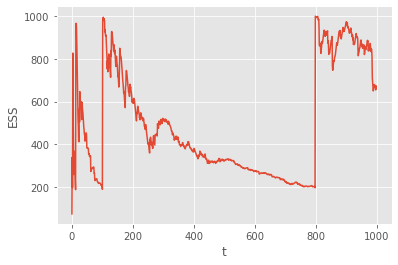

In [11]:
plt.plot(alt_alg.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS')

As expected, the algorithm waits until the ESS is below 200 to trigger a resample-move step.

## SMC tempering

SMC tempering is a SMC sampler that samples iteratively from the following sequence of distributions:

\begin{equation}
\pi_t(\theta) \propto \pi(\theta) L(\theta)^\gamma_t
\end{equation}

with $0=\gamma_0 < \ldots < \gamma_T = 1$. In words, this sequence is a **geometric bridge**, which interpolates between the prior and the posterior. 

SMC tempering implemented in the same was as IBIS: as a sub-class of `FeynmanKac`, whose `__init__` function takes as argument a `StaticModel` object. 

In [12]:
fk_tempering = ssp.AdaptiveTempering(my_static_model)
my_temp_alg = particles.SMC(fk=fk_tempering, N=1000, ESSrmin=1., verbose=True)
my_temp_alg.run()

t=0, ESS=500.00, tempering exponent=3.02e-05
t=1, Metropolis acc. rate (over 5 steps): 0.243, ESS=500.00, tempering exponent=0.000328
t=2, Metropolis acc. rate (over 7 steps): 0.245, ESS=500.00, tempering exponent=0.00177
t=3, Metropolis acc. rate (over 7 steps): 0.241, ESS=500.00, tempering exponent=0.00601
t=4, Metropolis acc. rate (over 7 steps): 0.288, ESS=500.00, tempering exponent=0.0193
t=5, Metropolis acc. rate (over 6 steps): 0.333, ESS=500.00, tempering exponent=0.0637
t=6, Metropolis acc. rate (over 5 steps): 0.366, ESS=500.00, tempering exponent=0.231
t=7, Metropolis acc. rate (over 6 steps): 0.357, ESS=500.00, tempering exponent=0.77
t=8, Metropolis acc. rate (over 5 steps): 0.358, ESS=943.23, tempering exponent=1


**Note**: Recall that `SMC` resamples every time the ESS drops below value N times option `ESSrmin`; here we set it to to 1, since we want to resample at every time. This makes sense: Adaptive SMC chooses adaptively the successive values of $\gamma_t$ so that the ESS drops to $N/2$ (by default). 

**Note**: we use option `verbose=True` in `SMC` in order to print some information on the intermediate distributions. 

We have not saved the intermediate results this time (option `store_history` was not set) since they are not particularly interesting. Let's look at the final results: 

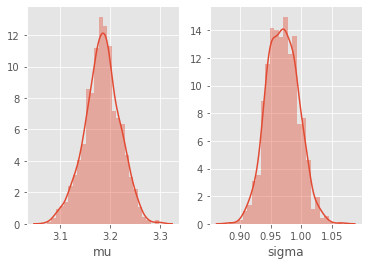

In [13]:
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    sb.distplot(my_temp_alg.X.theta[p])
    plt.xlabel(p)

This looks reasonable!
You can see from the output that the algorithm automatically chooses the tempering exponents $\gamma_1, \gamma_2,\ldots$. In fact, at iteration $t$, the next value for $\gamma$ is set that the ESS drops at most to $N/2$. You can change this particular threshold by passing argument ESSrmin to TemperingSMC. (Warning: do not mistake this with the `ESSrmin` argument of class `SMC`):

In [14]:
lazy_tempering = ssp.AdaptiveTempering(my_static_model, ESSrmin = 0.1)
lazy_alg = particles.SMC(fk=lazy_tempering, N=1000, verbose=True)
lazy_alg.run()

t=0, ESS=100.00, tempering exponent=0.00104
t=1, Metropolis acc. rate (over 6 steps): 0.247, ESS=100.00, tempering exponent=0.0208
t=2, Metropolis acc. rate (over 6 steps): 0.295, ESS=100.00, tempering exponent=0.514
t=3, Metropolis acc. rate (over 6 steps): 0.370, ESS=760.26, tempering exponent=1


The algorithm progresses faster this time, but the ESS drops more between each step.
Another optional argument for Class `TemperingSMC` is `options_mh`, which works exactly as for `IBIS`, see above. That is, by default, the particles are moved according to a certain (adaptative) number of random walk steps, with a variance calibrated to the particle variance.